In [25]:
from tqdm import tqdm
import os
import scipy.io
from scipy.spatial import distance as dist
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import cv2
import glob
from PIL import Image
from PIL import ImageEnhance
import pandas as pd
pd.set_option('display.max_colwidth', None)

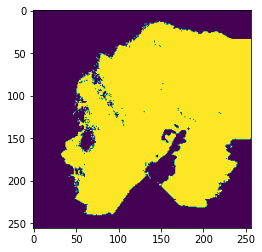

In [34]:
img = cv2.imread("img0.jpeg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filtro = cv2.pyrMeanShiftFiltering(img, 20, 40)
gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thresh)

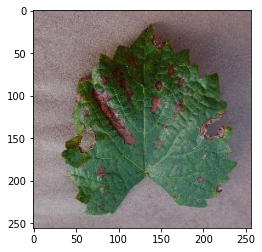

In [18]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Code Explanation

Hello, I will now shortly try to explain the logic behind my code.

There are two methods. segment_img() acts as a wrapper for the find_peaks2 method meaning that it will translate an input image into an array accepted by the find peaks method and uses the results of the find peaks to reconstruct an image and plot it
The two optimization methods (basin attraction and points along) are marked with comments in the code
The optimizations are not coded as separate methods as they are only a few lines long or in the case of basin attraction one line
In this implementation a pixel first gets the index of the corresponding peak assigned. Later in the wrapper functions, the picture will be reconstructed with the actual peak value
Therefore if a peak was added to the peaks list the index of the last added element is len()-1
If a peak did not get merged then the index if the argmin of the distances as it will be assigned to the closest peak
In this case, a pixel_list is also returned which can be used for the plotClusters3D class but is otherwhise, not necessary

In [19]:
def segment_img(img, r, c, add_pos = True):
    # Used for plotting in the end
    orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Used for mean shift
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    shape = img.shape
    
    # Add positional information to feature vector
    if add_pos:
        indices = np.ones((img.shape[0], img.shape[1], 2))
        row, column = np.indices(img.shape[0:2])
        indices[:, :, 0] = row
        indices[:, :, 1] = column
        img = np.append(img, indices, axis = 2)
        img = img.reshape(-1,5)
    else:
        img = img.reshape(-1, 3)
    
    # Call mean shift algorithm
    peaks, labels, pixel_list = find_peak(img, r, c)
    
    # Reconstruct image from peaks and labels
    rec_img = np.zeros(shape, dtype="uint8")
    rec_img = rec_img.reshape(-1,3)
    for unique in np.unique(labels):
        rec_img[labels == unique] = peaks[unique][0:3]
    rec_img = rec_img.reshape(shape)
    rec_img = cv2.cvtColor(rec_img, cv2.COLOR_LAB2BGR)

    # Plot image
    f, ax = plt.subplots(1,2, figsize= (12,8))
    ax[0].imshow(orig_img)
    ax[0].set_title("Original")
    ax[1].imshow(rec_img)
    ax[1].set_title("Segmented")
    
    return  peaks, labels, rec_img,pixel_list

In [20]:
def find_peak(pixel_list,r,c):
    # Reshape img to have one entry for each pixel
    threshold = 0.01
    peaks = []
    # Fill labels with a volue which can not be an index
    labels = np.full(len(pixel_list),-1)
    for count,p in enumerate(tqdm(pixel_list)):
        
        # Check if a label was already assigned 
        if labels[count] == -1:
            #Optimization 2 = Points along
            add_pixels = np.zeros(len(pixel_list))
            # Rese shift to arbitrary value above threshold
            shift = 5
            while shift > threshold:
                dist_pixel = cdist([p], pixel_list)[0]
                window = pixel_list[dist_pixel < r]
                #Optimization 2 = Points along
                add_pixels[np.where(dist_pixel < r/c)] = 1
                
                center_mass = window.mean(axis=0)
                shift = dist.euclidean(p, center_mass)
                p = center_mass
            
            # Add the first peak
            if len(peaks) == 0:
                peaks.append(center_mass)
                # Basin attraction
                labels[cdist([center_mass], pixel_list)[0] < r] = len(peaks) -1
                # Optimization 2 = Points along
                labels[add_pixels ==1] = len(peaks) -1
                continue
            
            # Check if peak should be merged or added
            distances = cdist([center_mass], peaks)
            if distances.min() > r/2:
                peaks.append(center_mass)
                # Basin attraction
                labels[cdist([center_mass], pixel_list)[0] < r] = len(peaks) -1
                # Optimization 2 
                labels[add_pixels ==1] = len(peaks) -1
            # Case in which a peak got merged
            else:
                labels[count] = distances.argmin()
                # Optimization 2 
                labels[add_pixels ==1] = distances.argmin()             
        else:
            continue
    
    return np.array(peaks), labels, pixel_list

100%|██████████| 65536/65536 [00:33<00:00, 1982.58it/s] 


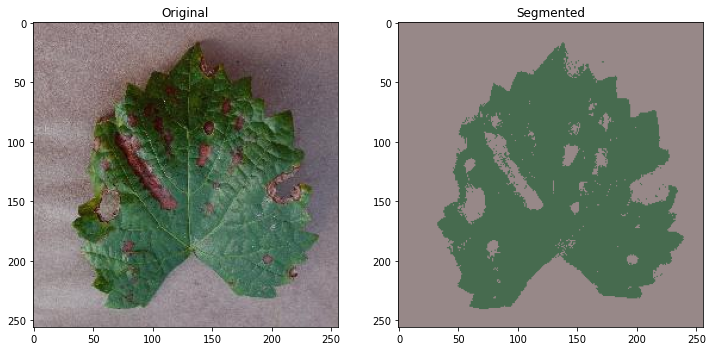

In [21]:
window_size = 20
search_along_divide = 4
peaks,labels, img_,pixel_list  =segment_img(img, window_size, search_along_divide, False)

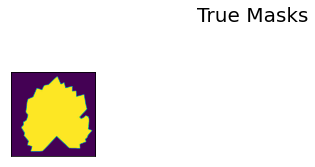

In [37]:
img_masks = []
# mask_path = './Masks/'
# for files in tqdm(glob.glob(os.path.join(mask_path,"*.JPEG"))):
#   img = Image.open(files)
#   img_masks.append(cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2GRAY))

img= cv2.imread("mask0.jpeg")
img_masks.append(cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2GRAY))
plt.figure(figsize=(9,9))
for i, img in enumerate(img_masks[0:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.suptitle("True Masks", fontsize=20)
plt.show()

In [39]:
def print_IOU(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    union = 0
    intersection = 0

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 or seg_mask_img[i][j]!=0 :
                union+=1
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0:
                intersection += 1
    
    iou = intersection/union

    print("IOU for image is ", iou)

print_IOU(thresh,img)

IOU for image is  0.7237243342142712


In [40]:
def print_pixel_accuracy(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    correct_pixel = 0
    total_pixel = h*w

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0:
                correct_pixel += 1
            if org_mask_img[i][j]==0 and seg_mask_img[i][j]==0:
                correct_pixel += 1
    
    accuracy = correct_pixel / total_pixel

    print("Pixel Accuracy for image  is ", accuracy)
print_pixel_accuracy(thresh,img)

Pixel Accuracy for image  is  0.8341064453125


In [41]:
def print_f1_score(seg_mask_img, org_mask_img):
    h,w = seg_mask_img.shape
    overlap = 0

    pixel_1 = 0
    pixel_2 = 0

    for i in range(0, h):
        for j in range(0,w):
            if org_mask_img[i][j]!=0 and seg_mask_img[i][j]!=0 :
                overlap+=1
            if org_mask_img[i][j]!=0 :
                pixel_1 += 1
            if seg_mask_img[i][j]!=0:
                pixel_2 += 1
    
    f1 = 2*(overlap)/(pixel_2 + pixel_1)

    print("F1 score for image is ", f1)
print_f1_score(thresh,img)

F1 score for image is  0.8397216652907182
